## Amazon SageMaker DICOM Training Overview

In this example we will demonstrate how to integrate the [MONAI](http://monai.io) framework into Amazon SageMaker, use SageMaker Ground Truth labelled data, and give example code of MONAI pre-processing transforms and neural network (DenseNet) that you can use to train a medical image classification model using DICOM images directly.  Please also visit [Build a medical image analysis pipeline on Amazon SageMaker using the MONAI framework](https://aws.amazon.com/blogs/industries/build-a-medical-image-analysis-pipeline-on-amazon-sagemaker-using-the-monai-framework/) for additional details on how to deploy the MONAI model, pipe input data from S3, and perform batch inferences using SageMaker batch transform.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

Sample dataset is obtained from this [source COVID-CT-MD](https://github.com/ShahinSHH/COVID-CT-MD). The dataset contains volumetric chest CT scans (DICOM files) of 169 patients positive for COVID-19 infection, 60 patients with CAP (Community Acquired Pneumonia), and 76 normal patients. 

In [48]:
!pip install -r ./source/requirements.txt
!mkdir -p data

In [ ]:
!pip install --upgrade torch torchvision  ## upgrade torchvision to ensure consistent performance

In [21]:
import os
from pathlib import Path
from dotenv import load_dotenv
env_path = Path('.') / 'set.env'
load_dotenv(dotenv_path=env_path)

bucket="dataset-pathology"
bucket_path=os.environ.get('BUCKET_PATH')
user=os.environ.get('DICOM_USER')
password = os.environ.get('DICOM_PASSWORD')

print('Bucket: '+bucket)

Bucket: dataset-pathology


## Training Dataset in S3

In [22]:
from sagemaker.s3 import S3Downloader, S3Uploader
bucket="s3://dataset-pathology"
key='CovidTrainingV2'
path=os.path.join(bucket,key)
file_list=S3Downloader.list(path) ## all the DICOM files for model training

## Amazon SageMaker GroundTruth Labeling Metadata

Download and parse the GroundTruth JSON annotation file for labelled data, classes and DICOM image URLs. 

In [23]:
import json
import boto3
s3 = boto3.client('s3')

image_url_list = []
image_label_list = []


In [18]:
# Get SageMaker GroundTruth labeling data from annotation file manifest.json

datadir = './data'
metadata = datadir+'/manifest.json'

## DICOM Upload Files to S3

Download the DICOM files from Orthanc DICOM Server into S3 for SageMaker training.

You may skip the step if the data is already saved in S3

In [19]:
import urllib3
import requests
import os
from io import BytesIO
import contextlib;
urllib3.disable_warnings()

image_file_list = []

#Load DICOM images to S3
for i, j in enumerate(image_url_list):
    file_name = image_url_list[i].split("/file")[0].split("instances/")[1] + '.dcm'
    response = requests.get(image_url_list[i], auth=(user, password), stream=True, verify=False)
    fp = BytesIO(response.content)
    s3.upload_fileobj(fp, bucket, file_name)   
    image_file_list.append(file_name)

## DICOM Display Sample Set

Download a sample of DICOM images from the S3 bucket and display with label from annotation file.

In [23]:
datadir='/home/ec2-user/SageMaker/annotate-medical-images-in-dicom-server-and-build-ml-models-on-amazon-sagemaker/notebook/data2'
image_file_list=os.listdir(datadir)

In [26]:
import monai
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, ToTensor, SqueezeDim,RandRotate,RandFlip,RandZoom
import matplotlib.pyplot as plt


## Preprocess the dataset and display them

In [148]:
## preprocess the dataset before trainining using MONAI.  based on img.shape, this is a channel last image
train_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    #RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    Resize(spatial_size=(512,-1)),
    ToTensor()
])
img = train_transforms(datadir+'/'+image_file_list[0])
img.shape ## check image size after preprocessing

torch.Size([512, 512, 1])

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


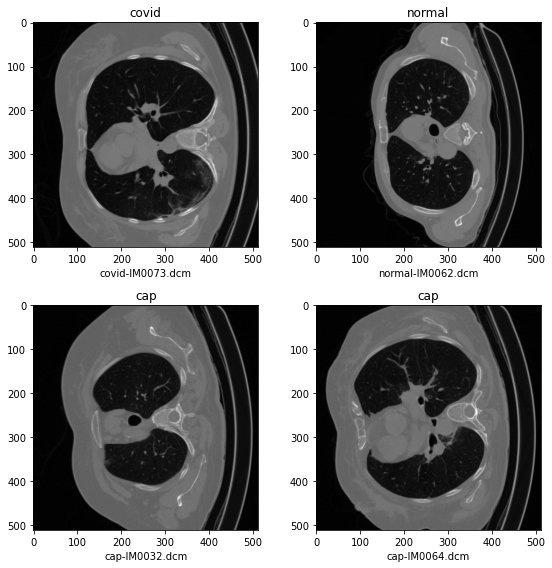

In [24]:
import monai
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, ToTensor, SqueezeDim
import matplotlib.pyplot as plt

#Display sample of DICOM Images
inf_test = []
inf_test_label = []

trans = Compose([LoadImage(image_only=True), Resize(spatial_size=(512,-1))])
plt.subplots(2, 2, figsize=(8, 8))
for i in range(0,4):
    #s3.download_file(bucket, image_file_list[i], datadir+'/'+image_file_list[i])
    
    img = trans(datadir+'/'+image_file_list[i])
    print(img.shape)
    plt.subplot(2, 2, i + 1)
    plt.xlabel(image_file_list[i])
    plt.imshow(img, cmap='gray')
    plt.title(image_file_list[i].split('-')[0])
    inf_test.append(datadir+'/'+image_file_list[i])
    inf_test_label.append(image_file_list[i].split('-')[0])
    
plt.tight_layout()
plt.show()

## Data

### Create Sagemaker session and S3 location for DICOM dataset

In [3]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
inputs='s3://dataset-pathology/CovidTrainingV2'

## IF WE UPLOAD THE DATA TO S3, DO THE FOLLOWING STEP
#inputs = sagemaker_session.upload_data(path=datadir, bucket=bucket)
print('input spec as an S3 path: {}'.format(inputs))

input spec as an S3 path: s3://dataset-pathology/CovidTrainingV2


## Train Model
### Training

The ```monai_dicom.py``` script provides all the code we need for training and hosting a SageMaker model (model_fn function to load a model). The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
* SM_NUM_GPUS: The number of gpus available in the current container.
* SM_CURRENT_HOST: The name of the current container on the container network.
* SM_HOSTS: JSON encoded list containing all the hosts .
Supposing one input channel, 'training', was used in the call to the PyTorch estimator's fit() method, the following will be set, following the format SM_CHANNEL_[channel_name]:

* SM_CHANNEL_TRAINING: A string representing the path to the directory containing data in the 'training' channel.
For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

In [7]:
!pygmentize source/monai_dicom.py

# Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

import argparse
import json
import logging
import os
import sys
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from monai.config import print_config
from monai.transforms import \
    Compose, LoadImage, Resize, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


class DICOMDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = tran

## Run training in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure.  We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters.  In this case we are going to run our training job on ```ml.m5.xlarge``` instance.  But this example can be ran on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)).  The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the ```monai_dicom.py``` script above.

In [13]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='monai_dicom_json.py',
                    source_dir='source',
                    role=role,
                    framework_version='1.5.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.m5.2xlarge',
                    hyperparameters={
                        'backend': 'gloo',
                        'epochs': 100
                    })

After we've constructed our PyTorch object, we can fit it using the DICOM dataset we uploaded to S3.

In [ ]:
%time
estimator.fit({'train': inputs})

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
2022-03-03 09:45:41 Starting - Starting the training job...
2022-03-03 09:45:44 Starting - Launching requested ML instancesProfilerReport-1646300741: InProgress
.........
2022-03-03 09:47:22 Starting - Preparing the instances for training......
2022-03-03 09:48:40 Downloading - Downloading input data
2022-03-03 09:48:40 Training - Downloading the training image...
2022-03-03 09:49:03 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-03 09:48:55,791 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-03 09:48:55,806 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-03 09:48:55,816 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-03 09:48:58,837 sagemaker_p

1/0, train_loss: 1.1260
epoch 1 average loss: 1.1260
----------
epoch 2/100
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.1139
epoch 2 average loss: 1.1139
----------
epoch 3/100
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.1023
epoch 3 average loss: 1.1023
----------
epoch 4/100
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.0908
epoch 4 average loss: 1.0908
----------
epoch 5/100
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.0746
epoch 5 average loss: 1.0746
----------
epoch 6/100
inputs shape is ----- torch.Size([25, 512, 512, 1])
inputs shape after is ----- torch.Size([25, 1, 512, 512])
1/0, train_loss: 1.0552
epoch 6 average loss: 1.0552
----------
epoch 

## deploy endpoint 

+ default inference 
[pytoch-inference-hander](https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_pytorch_inference_handler.py) 
+ customized setting [./source/inference.py]

In [ ]:
## Option 1: default
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

In [18]:
## Option 1: customized

predictor2 = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge',entry_point='inference.py',source_dir='source',
                            serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer())

-------!

In [19]:
%%time
payload={"bucket": "dataset-pathology",
    "key":"test_data/normal-IM0062.dcm"}

predictor2.predict(payload)

CPU times: user 11.8 ms, sys: 180 µs, total: 12 ms
Wall time: 3.07 s


{'results': {'class': 'Covid', 'probability': 0.46}}

In [12]:
predictor2 = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge',entry_point='inference.py',source_dir='source',
                            serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer())

-------!